# Scraping school supply budgets from the NYC DoE

Our goal is to get the school expenditure data from 2006 to 2012. Our strategy is to:
* Search the NYC School Based Expenditure report for each year for each school (DBN)
* Pull the school name from the search results, and then use this name to get the specific expenditure report.

In [1]:
import urllib2
import re
import pandas as pd
import numpy as np
from retrying import retry

##Retry decorator will retry every two seconds, for up to 10 seconds, if server side error
    
@retry(wait_fixed=2000, stop_max_delay=10000)
def search_by_year_and_DBN(year, DBN):
    
    ## build keys for results dictionary
    tot_exp_key = 'total_expenditure_' + str(year)
    per_stu_key = 'per_student_' + str(year)
    percent_exp_key = 'percent_of_all_expenditures_' + str(year)

    ##build initial query using year and DBN
    years = str(year-1) + '_' + str(year)
    query = ("https://www.nycenet.edu/offices/d_chanc_oper/budget/exp01/y" + years +
             "/function.asp?district=All&search=" + DBN +
             "&searchgo=Search&LCMS=**&GRANT=NO&cr1=All&cr2=All&cr3=All&cr4=All&R=1&prior=search")
    
    ##get school name by searching html page returned from query- if not found, return series of NaNs.
    try:
        response = urllib2.urlopen(query)
        search_results = response.read()
    except urllib2.HTTPError:
        results = {tot_exp_key: np.nan, per_stu_key: np.nan, percent_exp_key: np.nan}
        return pd.Series(results, name=DBN)
        
    try:
        school_name = re.findall('Search\sResults\s--\sSchool\sList.*?\n', search_results)
        school_name = re.findall(r'\"(.+?)\"', school_name[0])
        school_name = re.sub('\s', '+', school_name[0])
        school_name = re.sub('\+\++','', school_name)
    except:
        results = {tot_exp_key: np.nan, per_stu_key: np.nan, percent_exp_key: np.nan}
        return pd.Series(results, name=DBN)
    
    ##if found, use school name to build new query to get expenditure report for year:
    query2 = ("https://www.nycenet.edu/offices/d_chanc_oper/budget/exp01/y" + years +
             "/function.asp?district=&search=" + DBN + "&LCMS=" + school_name +
             "&schoolgo=Go&GRANT=NO&cr1=All&cr2=All&cr3=All&cr4=All&R=1&prior=search")
    try:
        response = urllib2.urlopen(query2)
        search_results = response.read()
    except urllib2.HTTPError:
        results = {tot_exp_key: np.nan, per_stu_key: np.nan, percent_exp_key: np.nan}
        return pd.Series(results, name=DBN)
        
    ##parse expenditure report to determine instructional equipment and supplies expenditures
    target_row_in_expenditure_report = re.findall('Instructional\&nbsp;Supplies.*?Professional\&nbsp;Development', search_results)
    expense_records = re.findall(r'\$\d*,?\d*', target_row_in_expenditure_report[0])
    total_expenditure = re.sub('\$|,', '', expense_records[0])
    per_student = re.sub('\$|,', '', expense_records[1])
    percent = re.findall(r'\d+\.\d+\%', target_row_in_expenditure_report[0])
    percent_of_all_expenditures = float(re.sub('\%','', percent[0]))/100.0
    
    results = {tot_exp_key: total_expenditure, per_stu_key: per_student, percent_exp_key: percent_of_all_expenditures}
    results = pd.Series(results, name=DBN)
    return results


Now, we need to import the list of school DBN (which we can read in as unique values in the DBN feature in the School Demographic and Accountability Snapshot, 2006-2012).

In [2]:
def get_DBN_list():
    query = 'https://nycopendata.socrata.com/api/views/ihfw-zy9j/rows.csv?accessType=DOWNLOAD'
    Demo_and_Account = pd.read_csv(query)
    all_DBNs = Demo_and_Account['DBN']
    unique_DBNs = all_DBNs.unique()
    for i in range(len(unique_DBNs)):
        unique_DBNs[i] = unique_DBNs[i][2:]
    return unique_DBNs

In [3]:
def build_expenditure_dataframe(year):
    unique_DBNs = get_DBN_list()
    file_path = 'school_supply_expenditures_' + str(year)
    getting_first_school = True
    for DBN in unique_DBNs:
        if getting_first_school == True:
            results_for_year = search_by_year_and_DBN(year, DBN)
            getting_first_school = False
        else:
            school_results = search_by_year_and_DBN(year, DBN)
            results_for_year = pd.concat([results_for_year, school_results], axis=1)
    results_for_year = results_for_year.T
    return results_for_year

In [4]:
def save_2006_to_2012_data():
    for year in range(2006,2013):
        print 'Getting data for ', year
        save_path = "school_expenditures/school_expenditures_" + str(year) + ".csv"
        year_expenditure_data = build_expenditure_dataframe(year)
        year_expenditure_data.to_csv(save_path)
    print 'Done'

In [ ]:
save_2006_to_2012_data()

Now that we have the data, our next task is to merge all the years into a single data frame.

In [16]:
def merge_all_years():
    year_data = {}
    for year in range(2011,2013):
        path = 'school_expenditures/school_expenditures_' + str(year) + '.csv'
        year_data['year_{0}'.format(year)] =  pd.read_csv(path, index_col=0)    
    all_years = pd.concat(year_data.values(), axis=1, join='inner')
    return all_years

all_years = merge_all_years()

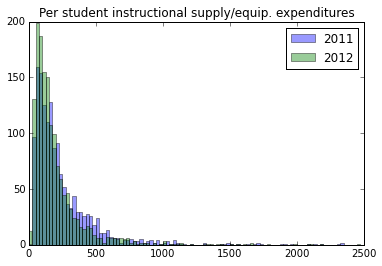

In [86]:
import matplotlib.pyplot as plt
%matplotlib inline 
plt.figure(1)
expenditures_2011 = plt.hist(all_years.per_student_2011.values, alpha=0.4, bins=100, range=[0,2500], label='2011')
expenditures_2012 = plt.hist(all_years.per_student_2012.values, alpha=0.4, bins=100, range=[0,2500], label='2012')
plt.legend()
plt.title('Per student instructional supply/equip. expenditures')

In [96]:
print max(all_years.per_student_2012.values)

7245.0
